# Тесты с генетическим алгоритмом

Требуется подобрать такие параметры НРС, чтобы при заданных условиях (например, при требуемом расходе воды и подаче на требуемое расстояние), состав сил и средств был минимальный.

Критерии оптимизации (пример для расхода и расстояния):


$$
|\sum_{i=1}^{n}{Q_i}-Q_{треб.}|\longrightarrow min
$$

$$
|L_{НРС}-L_{треб.}|\longrightarrow min
$$



Мутации добавления отдельных элементов невозможны, поэтому нужно делать мутации блоками:

* ствол с рукавной линией
* магистральная рукавная линия

Нет, не так!

Типы мутаций:

* Разбить составной элемент, вставив другой элемент,
* Удалить элемент
* Изменить параметры элемента (количество рукавов, тип рукавов)
* Добавить рабочую рукавную линию

Основные категории элементов НРС:

* Насос ПА (Pump)
* напорная рукавная линия (Hose)
* всасывающая рукавная линия (InHose)
* разветвление (Splitter)
* водосборник (Joiner)
* ствол (Nozzle)


Также нужно добавить элемент который будет очищать мусор в модели.

## Обертка над NRS которая будет реализовывать более тонкие функции ГА

In [1]:
from nrs import NRS_Model, Element, NRS_Revision, NRS_Observer_E    # классы НРС
from nrs import NRS_Data                                            # Табличные данные НРС
from nrs import q_out_simple, q_out_nozzle                          # модели расчета параметров
import matplotlib.pyplot as plt                                     # библиотеки для отрисовки получаемых данных
import networkx as nx
import random
import copy

import logging
logger = logging.getLogger('NRS')
# logger.setLevel(logging.DEBUG)
logging.basicConfig(level=logging.DEBUG)

In [2]:
def print_NRS_graph(model):
    '''
    Построение графа НРС
    '''
    try:
        G = nx.DiGraph()
        # Узлы - на каждый элемент
        for elmnt in model.elmnts:
            G.add_node(elmnt.name, q=elmnt.q)
        # Ребра - на каждую связь
        for elmnt in model.elmnts:
            for elmnt_next in elmnt.elements_next:
                G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())

        # Расчет расстояния до элементов
        for elmnt in model.elmnts_in:
            paths = nx.shortest_path_length(G, source = elmnt.name, weight='L')
            nx.set_node_attributes(G, paths, 'L')   # Здесь нужна другая логика
            print(f'Расстояние до {elmnt.name} {max(paths.values())} м')    

        # Печать графа НРС
        pos={}
        pos_list=[]
        level=0
        for eo in model.elmnts_in:
            v = eo.name
            spl = dict(nx.single_source_shortest_path_length(G, v))
            for nd, p in spl.items():
                if not nd in pos.keys():
                    level_rize=level
                    cpos = (p,level_rize)
                    while cpos in pos_list:
                        level_rize+=1
                        cpos = (p,level_rize)
                    pos[nd]=cpos
                    pos_list.append(cpos)
            level+=1

        nc = [nd[1]['L'] for nd in list(G.nodes(data=True))]
        nx.draw(G, pos=pos, with_labels=True, node_color=nc)
        plt.show()

        return G
    except:
        print('Полный граф изобразить не возможно, будет отображен упрощенный')
        return print_NRS_graph_simple(model)

def print_NRS_graph_simple(model):
    '''
    Построение графа НРС
    '''
    G = nx.DiGraph()
    # Узлы - на каждый элемент
    for elmnt in model.elmnts:
        G.add_node(elmnt.name, q=elmnt.q)
    # Ребра - на каждую связь
    for elmnt in model.elmnts:
        for elmnt_next in elmnt.elements_next:
            G.add_edge(elmnt.name, elmnt_next.name)

    nx.draw(G, with_labels=True)
    plt.show()

    return G

In [3]:
# from workFolder.nrs import q_out_simple


class GA_model(NRS_Model):
    '''
    Класс модели НРС адаптированный для работы ГА
    '''
    def __init__(self, name):
        self.pumps=[]
        self.hoses=[]
        self.inhoses=[]
        self.splitters=[]
        self.joiners=[]
        self.nozzles=[]
        super().__init__(name)

    def appendElement(self, elmnt):
        
        # super().appendElement(elmnt)

        if isinstance(elmnt, GA_Element_Pump):
            self.pumps.append(elmnt)
            if elmnt.name=='': elmnt.name='Н'+str(self.counter)
        if isinstance(elmnt, GA_Element_Hose):
            self.hoses.append(elmnt)
            if elmnt.name=='': elmnt.name='НРЛ'+str(self.counter)
        if isinstance(elmnt, GA_Element_InHose):
            self.inhoses.append(elmnt)
            if elmnt.name=='': elmnt.name='ВРЛ'+str(self.counter)
        if isinstance(elmnt, GA_Element_Splitter):
            self.splitters.append(elmnt)
            if elmnt.name=='': elmnt.name='Р'+str(self.counter)
        if isinstance(elmnt, GA_Element_Joiner):
            self.joiners.append(elmnt)
            if elmnt.name=='': elmnt.name='ВС'+str(self.counter)
        if isinstance(elmnt, GA_Element_Nozzle):
            self.nozzles.append(elmnt)
            if elmnt.name=='': elmnt.name='Ств'+str(self.counter)
            
        return super().appendElement(elmnt)

    def crossing(self, pair_model):
        return self

    def mutate(self):
        return self

    def check_pumps(self):
        '''
        Проверяет пожарные автомобили. 
        Для тех из них у которых есть только элементы на выход устанавливается e_type `0` (in).
        Для тех у кого имеются и те и те, ставится e_type `1` (inter).
        '''
        for elmnt in self.elmnts:
            if isinstance(elmnt, GA_Element_Pump):
                e_in = len(elmnt.elements_previous)
                e_out = len(elmnt.elements_next)
                if e_in==0 and e_out>0:
                    elmnt.type = 0
                if e_in>0 and e_out>0:
                    elmnt.type = 1
        return self
    

class GA_Element_Pump(Element):
    '''
    Класс элемента `Пожарного автомобиля с насосом` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type, H_min=10, Q_min=0, H_max=100, Q_max=40, 
        q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=2, q_out=...):
        
        self.id = 'GA_Element_Pump'
        self.H_min = H_min
        self.H_max = H_max
        self.Q_min = Q_min
        self.Q_max = Q_max
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def set_H_add(self, H_add):
        if H_add > self.H_max:
            self.H_add = self.H_max
        else:
            self.H_add = H_add
        if H_add <= self.H_min:
            self.H_add = self.H_min
        else:
            self.H_add = H_add

    def mutate(self):
        pass


class GA_Element_Hose(Element):
    '''
    Класс элемента `Рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, d='51', q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=20, ri=1, ro=1, q_out=...):
        self.id = 'GA_Element_Hose'
        self.d=d
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        mutation_case = random.choice([0,1])
        # мутация количества
        if mutation_case==0:
            change_val = random.choice([-1,1])
            if self.n+change_val>0:
                self.n = self.n+change_val
        # мутация диаметра
        if mutation_case==1:
            new_d=random.choice(list(NRS_Data.ss.keys()))
            self.d = new_d
            self.s = NRS_Data.ss[new_d]
        # мутация типа

        # разбиение

class GA_Element_InHose(Element):
    '''
    Класс элемента `Всасывающей рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=4, ri=1, ro=1, q_out=...):
        self.id = 'GA_Element_InHose'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        pass

class GA_Element_Splitter(Element):
    '''
    Класс элемента `Разветвление` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=3, q_out=...):
        self.id = 'GA_Element_Splitter'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        pass

class GA_Element_Joiner(Element):
    '''
    Класс элемента `Водосборник` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=1, q_out=...):
        self.id = 'GA_Element_Joiner'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        pass

class GA_Element_Nozzle(Element):
    '''
    Класс элемента `Ствол` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, n_type='Б', q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=0, q_out=...):
        '''
        `n_type` - тип ствола. `Б` - ручной ствол Б, `А` - ручной ствол А, `Л` - лафетный переносной, `ЛА` - лафетный автомобильный.
        '''
        self.id = 'GA_Element_Nozzle'
        self.n_type = n_type
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        pass

# Классы которые могут быть присоединены после элемента
allowed_append_classes = {
        'GA_Element_Pump': (GA_Element_Hose),
        'GA_Element_Hose': (GA_Element_Pump,GA_Element_Hose,GA_Element_Nozzle,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_InHose': (GA_Element_Pump),
        'GA_Element_Splitter': (GA_Element_Hose), #,GA_Element_Splitter),
        'GA_Element_Joiner': (GA_Element_Pump,GA_Element_Hose,GA_Element_Nozzle,GA_Element_Splitter),
        'GA_Element_Nozzle': (),
    }
# Классы которые могут быть присоединены перед элементом
allowed_prepend_classes = {
        'GA_Element_Pump': (GA_Element_Hose,GA_Element_Joiner,GA_Element_InHose),
        'GA_Element_Hose': (GA_Element_Pump,GA_Element_Hose,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_InHose': (),
        'GA_Element_Splitter': (GA_Element_Hose,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_Joiner': (GA_Element_Hose),
        'GA_Element_Nozzle': (GA_Element_Hose,GA_Element_Joiner),
    }


# (GA_Element_Hose,GA_Element_Pump,GA_Element_Nozzle,GA_Element_Joiner,GA_Element_Splitter,GA_Element_InHose)

## Проверка

In [ ]:

#====================================================================================================================================
# Вычисляем проводимость насадка для ствола Б
p_nozzleB = NRS_Revision.calc_p(3.7, 40)
p_nozzleA = NRS_Revision.calc_p(7.4, 40)
p_nozzleL = NRS_Revision.calc_p(16, 40)

# Элементы
# pump = GA_Element_Pump('Насос', e_type=0, H_add=40)                                
# hoseW1 = GA_Element_Hose('РЛ1', e_type=1, s=NRS_Data.ss["51"], n=5)             
# nozzle1 = GA_Element_Nozzle('Ств1', e_type=2, p=p_nozzleB, q_out = q_out_nozzle)
pump = GA_Element_Pump('', e_type=1, H_add=40)                                
hoseW1 = GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=5)             
nozzle1 = GA_Element_Nozzle('', e_type=2, p=p_nozzleB, q_out = q_out_nozzle)

# Соединяем элементы
pump.append(hoseW1).append(nozzle1)

# Добавляем наблюдателей
watcher_pump = NRS_Observer_E(pump, ['q', 'H_add'])         # Для насоса. Наблюдаем изменения расхода и дополнительного напора (создаваемого насосом)
watcher_nozzle1 = NRS_Observer_E(nozzle1, ['q', 'H_in'])    # Для ствола. Наблюдаем изменения расхода и напора на входе

# Сборка модели
model = GA_model('Тест простой модели для ГА')
# model.build(pump, interpretate=True).observersInit()
# model.addElements([pump, hoseW1, nozzle1], interpretate=True).observersInit()
model.addElements([pump, hoseW1, nozzle1]).check_pumps().interpretate().observersInit()


# Расчет 
model.calc(accuracy=0.05)
print(model.summaryQ(), end='\n\n')

print('Статус насоса:')
NRS_Revision.print_element_state(pump, ['H_add', 'q'])

In [4]:
NRS_Revision.print_model_elements(model)

all:
  Н0
  НРЛ1
  Ств2
in:
  Н0
out:
  Ств2


In [5]:
NRS_Revision.print_element_state(pump)

elements_next: [<__main__.GA_Element_Hose object at 0x000001B1419ABC20>]
elements_previous: []
type: 0
name: Н0
q: 3.3423464007615813
s: 0
H_in: 0
h: 0.0
z: 0
p: 1
n: 1
q_out: Ellipsis
H_add: 40
observer: <nrs.NRS_Observer_E object at 0x000001B141660E60>
l: 0
ri: 2
ro: 2
H_out: 40.0


In [6]:
random.choice(list(NRS_Data.ss.keys()))

'66нп'

In [7]:
model.pumps

In [10]:
# hoseW2 = GA_Element_Hose('РРЛ2', e_type=1, s=NRS_Data.ss["77"], n=5)
hoseW2 = GA_Element_Hose('', e_type=1, s=NRS_Data.ss["77"], n=5)

# Удаляем из ссылок текущего элемента ссылку на следующий элемент
# Выбираем текущий элемент
# hoseW1
# Определяем какой именно элемент из списка следующих удаляем
next_e = hoseW1.elements_next[0]
del hoseW1.elements_next[0]
del next_e.elements_previous[0]
hoseW1.append(hoseW2).append(next_e)

# Пересобираем модель
# model.clear().build(hoseW1, interpretate=True).observersInit()
# model.build(hoseW1, interpretate=True).observersInit()
model.appendElement(hoseW2)
model.check_pumps().interpretate()   #.observersInit()

# Расчет 
model.calc(accuracy=0.05)
print(model.summaryQ(), end='\n\n')

print('Статус насоса:')
NRS_Revision.print_element_state(pump, ['H_add', 'q'])

3.294450493638155

Статус насоса:
H_add: 40
q: 3.294450493638155


In [11]:
NRS_Revision.print_model_elements(model)

all:
  Н0
  НРЛ1
  Ств2
  НРЛ3
in:
  Н0
out:
  Ств2


In [12]:
pump2 = GA_Element_Pump('', e_type=1, H_add=40).addToModel(model)              
hoseM2 = GA_Element_Hose('', e_type=1, s=NRS_Data.ss["77"], n=10).addToModel(model)
pump2.append(hoseM2).append(pump)

# model.appendElement(hoseW2)
model.check_pumps().interpretate()

# Расчет 
model.calc(accuracy=0.05)
print(model.summaryQ(), end='\n\n')

print('Статус насоса 1:')
NRS_Revision.print_element_state(pump, ['H_add', 'q'])
print('Статус насоса 2:')
NRS_Revision.print_element_state(pump2, ['H_add', 'q'])

4.581690610099076

Статус насоса 1:
H_add: 40
q: 4.581690610099076
Статус насоса 2:
H_add: 40
q: 4.581690610099076


## Визуализация

Расстояние до Н0 200 м
Расстояние до Н4 400 м


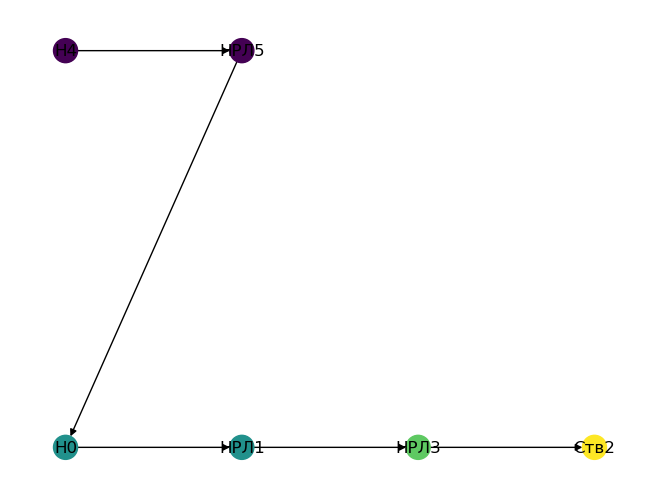

In [16]:
G = print_NRS_graph(model)

In [17]:
list(G.nodes(data=True))

[('Н0', {'q': 4.581690610099076, 'L': 200}),
 ('НРЛ1', {'q': 4.581690610099076, 'L': 200}),
 ('Ств2', {'q': 4.581690610099076, 'L': 400}),
 ('НРЛ3', {'q': 4.581690610099076, 'L': 300}),
 ('Н4', {'q': 4.581690610099076, 'L': 0}),
 ('НРЛ5', {'q': 4.581690610099076, 'L': 0})]

# Тесты

In [4]:
p_nozzleB = NRS_Revision.calc_p(3.7, 40)
p_nozzleA = NRS_Revision.calc_p(7.4, 40)
p_nozzleL = NRS_Revision.calc_p(16, 40)
p_nozzleB, p_nozzleA, p_nozzleL

(0.5850213671311502, 1.1700427342623003, 2.5298221281347035)

In [5]:
def get_elements_sack():
    elements_sack = []
    elements_sack.append(GA_Element_Pump('', e_type=1, H_add=40))
    # elements_sack.append(GA_Element_Pump('', e_type=0, H_add=60))
    # elements_sack.append(GA_Element_Pump('', e_type=0, H_add=80))
    elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2))
    elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2))
    elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2))
    elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2))
    elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2))
    # elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=4))
    # elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=6))
    elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["77"], n=2))
    elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["77"], n=2))
    # elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["77"], n=4))
    # elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["77"], n=6))
    elements_sack.append(GA_Element_Nozzle('', e_type=2, p=p_nozzleB, q_out = q_out_nozzle))
    elements_sack.append(GA_Element_Nozzle('', e_type=2, p=p_nozzleB, q_out = q_out_nozzle))
    elements_sack.append(GA_Element_Nozzle('', e_type=2, p=p_nozzleA, q_out = q_out_nozzle))
    # elements_sack.append(GA_Element_Nozzle('', e_type=2, p=p_nozzleA, q_out = q_out_nozzle))
    # elements_sack.append(GA_Element_Nozzle('', e_type=2, p=p_nozzleL, q_out = q_out_nozzle))
    # elements_sack.append(GA_Element_Joiner('', e_type=1, ri=2, ro=1))
    elements_sack.append(GA_Element_Splitter('', e_type=1, ri=1, ro=3))

    return elements_sack

## Слепой часовщик

In [52]:
tmp_list = [e for e in elements_sack]

while len(tmp_list)>0:
    elmnt = tmp_list.pop(random.randrange(len(tmp_list)))
    # next_elmnt  = random.choice(elements_sack)
    elements_for_append = [e for e in elements_sack if e!=elmnt]
    elmnt.append(random.choice(elements_for_append))

# Сборка модели
model = GA_model('Тест слепой часовщик')
# model.build(pump, interpretate=True).observersInit()
# model.addElements([pump, hoseW1, nozzle1], interpretate=True).observersInit()
model.addElements(elements_sack).check_pumps().interpretate()  #.observersInit()

# Расчет 
model.calc(accuracy=0.05)
print(model.summaryQ(), end='\n\n')

print('Статус насоса:')
NRS_Revision.print_element_state(pump, ['H_add', 'q'])

Новая модель: Тест слепой часовщик


KeyboardInterrupt: 

Расстояние до Н0 0 м
Полный граф изобразить не возможно, будет отображен упрощенный


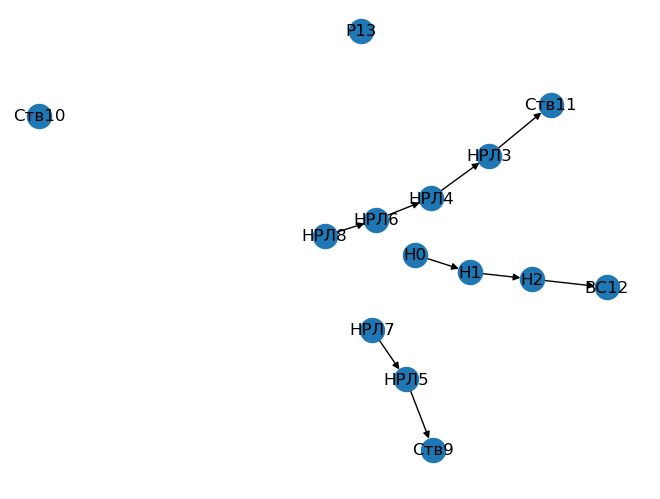

In [54]:
print_NRS_graph(model)

In [55]:
NRS_Revision.print_model_elements(model)

all:
  Н0
  Н1
  Н2
  НРЛ3
  НРЛ4
  НРЛ5
  НРЛ6
  НРЛ7
  НРЛ8
  Ств9
  Ств10
  Ств11
  ВС12
  Р13
in:
  Н0
out:
  Ств9
  Ств10
  Ств11


## Построение деревьев

In [6]:
def pop_random_element_by_class(lst, element_class=None, lst_left=False):
    '''
    Извлечение из списка элемента по классу

    `lst`
        Список элементов

    `element_class`
        Класс(ы) элементов

    `lst_left`
        Если True, то список сохраняется, иначе элемент будет удален.
    '''
    elmnt = None
    if element_class is None:
        elmnt = random.choice(lst)
    else:
        while not isinstance(elmnt, element_class):
            elmnt = random.choice(lst)
        
    if lst_left:
        return copy.deepcopy(elmnt)
    else:
        return copy.deepcopy(lst.pop(NRS_Revision.get_element_by_name(lst, elmnt.name)))
        # return lst.pop(NRS_Revision.get_element_by_name(lst, elmnt.name))
    
def element_class_test(lst, element_class):
    for elmnt in lst:
        if isinstance(elmnt, element_class):
            return True
    return False

def drop_elements_links(lst):
    for elmnt in lst:
        elmnt.drop_links()

In [59]:
model = GA_model('Тест имен')
model.addElements(elements_sack)

INFO:NRS:Новый элемент НРС: Н0
INFO:NRS:Новый элемент НРС: НРЛ1
INFO:NRS:Новый элемент НРС: НРЛ2
INFO:NRS:Новый элемент НРС: НРЛ3
INFO:NRS:Новый элемент НРС: НРЛ4
INFO:NRS:Новый элемент НРС: НРЛ5
INFO:NRS:Новый элемент НРС: НРЛ6
INFO:NRS:Новый элемент НРС: НРЛ7
INFO:NRS:Новый элемент НРС: Ств8
INFO:NRS:Новый элемент НРС: Ств9
INFO:NRS:Новый элемент НРС: Ств10
INFO:NRS:Новый элемент НРС: Р11


Новая модель: Тест имен


In [ ]:
print(len(elements_sack))
elmnt1 = pop_random_element_by_class(elements_sack, element_class=(GA_Element_Hose,GA_Element_Pump), lst_left=False)
elmnt2 = pop_random_element_by_class(elements_sack, lst_left=False)
print(len(elements_sack))
print(elmnt1.name, elmnt2.name)

In [15]:
print(element_class_test(elements_sack, GA_Element_Pump))
print(element_class_test(elements_sack, GA_Element_InHose))

True
False


In [16]:
elements_sack, len(elements_sack)

([<__main__.GA_Element_Pump at 0x1d20dded590>,
 14)

### Тест прямого (явного) построения ветви

In [ ]:
model = GA_model('Тест деревья')
pump = pop_random_element_by_class(elements_sack, GA_Element_Pump, lst_left=True)
hose = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
nozzle = pop_random_element_by_class(elements_sack, GA_Element_Nozzle, lst_left=True)
pump.append(hose).append(nozzle)


model.addElements([pump,hose,nozzle]).check_pumps().interpretate()

NRS_Revision.print_model_elements(model)

print_NRS_graph(model)

### Тест рекурсивного построения дерева

DEBUG:NRS:Элемент <class '__main__.GA_Element_Pump'>, выходов 2
INFO:NRS:Новый элемент НРС: Н0
INFO:NRS:Новый элемент НРС: НРЛ1
INFO:NRS:Новый элемент НРС: Ств2
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\obsid\\.conda\\envs\\ox\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\obsid\\.conda\\envs\\ox\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal'

Новая модель: Тест дерева - рекурсия
12
11
9
all:
  Н0
  НРЛ1
  Ств2
in:
  Н0
out:
  Ств2
Расстояние до Н0 40 м


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comicbd.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\consolaz.ttf', name='Consolas', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ELEPHNT.TTF', name='Elephant', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCK.TTF', name='Rockwell', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\webdings.ttf', name='Webdings', style='normal', variant='normal', weight=400, stretch='normal', 

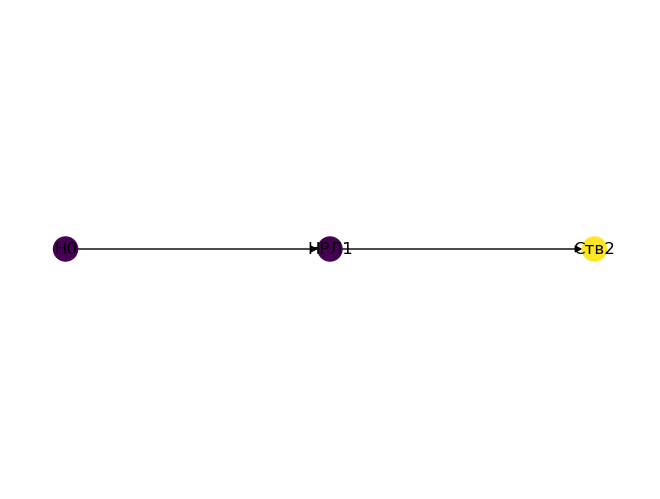

In [7]:
def pop_random_element_by_class(lst, element_class=None, lst_left=False):
    '''
    Извлечение из списка элемента по классу

    `lst`
        Список элементов

    `element_class`
        Класс(ы) элементов

    `lst_left`
        Если True, то список сохраняется, иначе элемент будет удален.
    '''
    elmnt = None
    if element_class is None:
        elmnt = random.choice(lst)
    else:
        if element_class_test(lst, element_class):
            while not isinstance(elmnt, element_class):
                elmnt = random.choice(lst)
        else:
            return None
        
    # if lst_left:
    #     return copy.deepcopy(elmnt)
    # else:
    #     return copy.deepcopy(lst.pop(NRS_Revision.get_element_by_name(lst, elmnt.name)))
    if lst_left:
        return elmnt
    else:
        # return lst.pop(NRS_Revision.get_element_by_name(lst, elmnt.name))
        idx = lst.index(elmnt)
        return lst.pop(idx)

def append_new_element(elmnt, elmnts_examples, add_elmnts_p=0.5, lst_left=True):
    '''
    Рекурсивное построение дерева НРС
    '''
    global depth
    if depth<=0:
        print('Достигнут предел рекурсии')
        return
    depth-=1

    # print(len(elements_sack))

    # ограничение списка приемлемых классов
    allowed_element_classes = allowed_append_classes[elmnt.id]
    # print(elmnt.id, 'Можно:')
    # print(allowed_element_classes)

    if elmnt.ro>0:
        # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
        # print(len(elmnts_examples))
        random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
        # if random_elmnt is None: return
        # print(len(elmnts_examples))
        if elmnt.append(random_elmnt):
            append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)

    for _ in range(elmnt.ro-1):
        logger.debug(f'Элемент {type(elmnt)}, выходов {elmnt.ro}')
        rnd = random.random()
        if rnd<=add_elmnts_p:
            # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
            # print(len(elmnts_examples))
            random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
            # if random_elmnt is None: return
            # print(len(elmnts_examples))
            if elmnt.append(random_elmnt):
                append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)

# global depth
depth=25


# Копия списка элементов (чтобы каждый раз не создавать его заново)
# global elements_sack_c
# elements_sack_c = copy.deepcopy(elements_sack)
elements_sack = get_elements_sack()


# Рекурсия
model = GA_model('Тест дерева - рекурсия')
print(len(elements_sack))
pump = pop_random_element_by_class(elements_sack, GA_Element_Pump, lst_left=False)
print(len(elements_sack))
append_new_element(pump, elements_sack, lst_left=False)  #, add_elmnts_p=1)
print(len(elements_sack))

model.build(pump).check_pumps().interpretate()

# model.addElements([pump,hose,nozzle]).check_pumps().interpretate()

NRS_Revision.print_model_elements(model)

print_NRS_graph(model)

In [8]:
elements_sack

In [43]:
# Расчет
# model.calc(iters=10)
model.calc(accuracy=0.05)
print(model.summaryQ(), end='\n\n')

3.5456084620390547



In [42]:
model.calc(accuracy=0.05)

(<__main__.GA_model at 0x1b0db343310>, 0, -81000)

In [26]:
model.calc(iters=10)

(<__main__.GA_model at 0x1b0db343310>, -6.914210981534552e-09)

In [41]:
model.drop_q()

In [27]:
print(model.summaryQ(), end='\n\n')

3.5456084620390547



In [110]:
NRS_Revision.print_model_elements(model)

all:
  Н0
  НРЛ1
  НРЛ2
  НРЛ3
  Р4
  НРЛ5
  Ств6
  НРЛ7
  Ств8
in:
  Н0
out:
  Ств6
  Ств8


In [111]:
# NRS_Revision.print_element_state(
#     NRS_Revision.get_element_by_name(model.elmnts, 'НРЛ1', False),
#     ['L', 's']
#     )
# NRS_Revision.print_element_state(
#     NRS_Revision.get_element_by_name(model.elmnts, 'НРЛ3', False),
#     ['L', 's']
#     )
NRS_Revision.print_element_state(
    NRS_Revision.get_element_by_name(model.elmnts, 'Ств6', False),
    ['p','q', 'H_in']
    )
NRS_Revision.print_element_state(
    NRS_Revision.get_element_by_name(model.elmnts, 'Ств8', False),
    ['p','q', 'H_in']
    )

p: 1.1700427342623003
q: (1.7898509347521625e-16+2.923048402197803j)
H_in: (-6.241206692177597+2.3092022000261308e-16j)
p: 0.5850213671311502
q: (3.545608462099151+0j)
H_in: (36.73145176481843+0j)


Нужно написать процедуру поиска и удаления промежуточных элементов, которые не имеют подключения на вход и выход.
Это рекурсивная процедура. 

Также нужна процедура которая удаляет несвязанные компоненты.

Нужна процедура получения ветви от произвольного элемента (при этом в ветви не должно быть насосов).

Нужно сделать мутации элементов и мутации модели (вставка и удаление ветвей, изменение типа элемента).

Скрещивание заключается в пересадке ветвей.